# DS-SF-38 | 18 | Natural Language Processing | Codelong | Answer Key

## >>> One-time setup

In [1]:
'''
import nltk
nltk.download()
'''

pass

## <<< One-time setup

## Part A | Tokenization and Stemming

In [2]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

import string
import unicodedata
from nltk import tokenize, corpus, stem

from sklearn import feature_extraction, linear_model, ensemble, model_selection, metrics

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Tokenization

In [3]:
def tokenize_text(document):
    document = document.encode('utf-8')

    # Convert text to lowercase
    document = document.lower()

    # Tokenize
    tokens = tokenize.word_tokenize(document)

    # Remove punctuation in tokens and then remove empty tokens
    tokens = [token.translate(None, string.punctuation) for token in tokens]
    tokens = [token for token in tokens if token]

    # Remove stop words
    tokens = [token for token in tokens if not token in corpus.stopwords.words('english')]

    return tokens

In [4]:
tokens = tokenize_text("This is a sentence...  Wait, here's another.  And a third!")

tokens

['sentence', 'wait', 'another', 'third']

## Stemming

In [5]:
class Stemmer:
    stemmer = stem.porter.PorterStemmer()

    @staticmethod
    def stem_tokens(tokens):
        return [Stemmer.stemmer.stem(token) for token in tokens]

In [6]:
tokens = Stemmer.stem_tokens(tokens)

tokens

[u'sentenc', 'wait', u'anoth', 'third']

## Part B | Text Classification

Below, we will be analyzing a partial list of the reviews for J.K. Rowling's The Casual Vacancy.  (https://www.amazon.com/dp/0316228532)  We scrapped this dataset during class 3.

In [7]:
df = pd.read_csv(os.path.join('..', 'datasets', 'dataset-18-reviews.csv'))

In [8]:
df

,date,id,author,title,body,star_rating
0,2017-10-23,R3OQUWVA2PRCEA,Jo B.,Five Stars,Good read,5.0
1,2017-10-12,R1FJA1XIBRBLES,Cheryl Dulin,Four Stars,A great kicker in the beginning AND the end yo...,4.0
2,2017-10-12,R3CFMLYBUJ0295,Eric P Albrecht,A clear triumph of a novel!,A clear triumph of a novel. Have always loved ...,4.0
3,2017-10-09,R1FMT3KY928NJB,tlckirk,Disappointing,If it were any other author I would have stopp...,2.0
4,2017-10-07,R138WXOO423PP4,Skelsogeo,Five Stars,A great read,5.0
...,...,...,...,...,...,...
5912,2012-09-27,RT2TE0W92SL67,Tricia K.,Seriously? $17 bucks for a computer file??? ...,Premise sounds dull as dirt. For $17 for a co...,1.0
5913,2012-09-27,R14ZGYPSP9H0Y7,Pretzel,A must read,The depth of character development and storyli...,5.0
5914,2012-09-27,R1913ISIDAGQ1A,Prodigy,I love it,The book was great and I will love to re-read ...,5.0
5915,2012-09-27,R2JY771IW7RI3R,David Katz,Kendle price too expensive,I started to order the kindle edition and than...,5.0


In [9]:
df.drop(['date', 'id', 'author', 'title'],
    axis = 1,
    inplace = True)

In [10]:
df

,body,star_rating
0,Good read,5.0
1,A great kicker in the beginning AND the end yo...,4.0
2,A clear triumph of a novel. Have always loved ...,4.0
3,If it were any other author I would have stopp...,2.0
4,A great read,5.0
...,...,...
5912,Premise sounds dull as dirt. For $17 for a co...,1.0
5913,The depth of character development and storyli...,5.0
5914,The book was great and I will love to re-read ...,5.0
5915,I started to order the kindle edition and than...,5.0


### `NaN`

In [11]:
df.isnull().sum()

body           3
star_rating    0
dtype: int64

In [12]:
df.dropna(inplace = True)

In [13]:
df.isnull().sum()

body           0
star_rating    0
dtype: int64

### Positive, neutral, and negatives reviews

In [14]:
df.star_rating.value_counts()

5.0    1548
1.0    1206
4.0    1203
2.0     983
3.0     974
Name: star_rating, dtype: int64

In [15]:
df['polarity'] = df.star_rating.map({1: -1, 2: -1, 3: 0, 4: 1, 5: 1})

In [16]:
ns = df.polarity.value_counts()

ns

 1    2751
-1    2189
 0     974
Name: polarity, dtype: int64

In [17]:
ns.min()

974

In [18]:
for polarity in [-1, 0, 1]:
    n = ns[polarity] - ns.min()
    index = df[df.polarity == polarity].sample(n = n, random_state = 0).index
    df.drop(index, inplace = True)

In [19]:
df.polarity.value_counts()

 1    974
-1    974
 0    974
Name: polarity, dtype: int64

### Feature matrix and response vector

In [20]:
X = df.body
c = df.polarity

In [21]:
X

0                                               Good read
3       If it were any other author I would have stopp...
4                                            A great read
6       5 Stars for writing 2 Stars for storytelling--...
11      I get it, J.K. Rowling wanted to do something ...
                              ...                        
5889    Okay, so I haven't read the whole book.  Just ...
5891    J.K. Rowling is best known for her Harry Potte...
5897    Just to set the record straight on Casual Vaca...
5908    This book shows a realistic, slightly cynical,...
5913    The depth of character development and storyli...
Name: body, dtype: object

In [22]:
c

0       1
3      -1
4       1
6       0
11     -1
       ..
5889   -1
5891    1
5897    0
5908    1
5913    1
Name: polarity, dtype: int64

### Train/test sets

In [23]:
train_X, test_X, train_c, test_c = model_selection.train_test_split(X, c, stratify = c, train_size = .6, random_state = 0)

In [24]:
train_c.value_counts()

 1    585
 0    584
-1    584
Name: polarity, dtype: int64

In [25]:
test_c.value_counts()

 0    390
-1    390
 1    389
Name: polarity, dtype: int64

### TF-IDF and `TfidfVectorizer`

In [26]:
'''
vectorizer = feature_extraction.text.TfidfVectorizer(stop_words = 'english')
'''

class CustomTokenizer(object):
    def __call__(self, document):
        tokens = tokenize_text(document)
        tokens = Stemmer.stem_tokens(tokens)
        return tokens

vectorizer = feature_extraction.text.TfidfVectorizer(tokenizer = CustomTokenizer(), ngram_range = (1, 3), min_df = 3)

In [27]:
vectorizer.fit(train_X)

### Bag-of-words

In [28]:
vectorizer.get_feature_names()

[u'1',
 u'10',
 u'10 book',
 u'100',
 u'100 page',
 u'12',
 u'13',
 u'14',
 u'15',
 u'16',
 u'17',
 u'1799',
 u'18',
 u'2',
 u'20',
 u'200',
 u'25',
 u'3',
 u'3 day',
 u'3 star',
 u'30',
 u'34',
 u'34 way',
 u'35',
 u'3rd',
 u'4',
 u'4 star',
 u'40',
 u'400',
 u'400 page',
 u'5',
 u'5 star',
 u'50',
 u'50 page',
 u'500',
 u'500 page',
 u'6',
 u'60',
 u'7',
 u'70',
 u'8',
 u'80',
 u'abandon',
 u'abil',
 u'abil creat',
 u'abil write',
 u'abl',
 u'abl finish',
 u'abl get',
 u'abl keep',
 u'abrupt',
 u'abruptli',
 u'absenc',
 u'absolut',
 u'absolut fascin',
 u'absolut love',
 u'absorb',
 u'abund',
 u'abus',
 u'accent',
 u'accept',
 u'accomplish',
 u'account',
 u'accur',
 u'acquaint',
 u'across',
 u'act',
 u'action',
 u'activ',
 u'actual',
 u'actual enjoy',
 u'ad',
 u'add',
 u'addict',
 u'addit',
 u'address',
 u'adject',
 u'adjust',
 u'admir',
 u'admir j',
 u'admir j k',
 u'admit',
 u'adolesc',
 u'ador',
 u'ador harri',
 u'ador harri potter',
 u'adult',
 u'adult audienc',
 u'adult book',
 u

### Transformed feature matrix `X`

In [29]:
train_X = vectorizer.transform(train_X)
test_X = vectorizer.transform(test_X)

In [30]:
train_X

<1753x4411 sparse matrix of type '<type 'numpy.float64'>'
	with 58694 stored elements in Compressed Sparse Row format>

While dense matrices store every entry in the matrix, sparse matrices only store the nonzero entries.  Sparse matrices don't have a lot of extra features, and some algorithms may not work for them so you use them when you need to work with matrices that would be too big for the computer to handle them, but they are mostly zero, so they compress easily.  You can convert from sparse matrices to dense matrices with `.todense()`

In [31]:
train_X.todense()

matrix([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

### Machine Learning Modeling

#### Logistic Regression

In [32]:
model = linear_model.LogisticRegression()

In [33]:
model_selection.cross_val_score(model, train_X, train_c, cv = 5).mean()

0.62180425962660912

In [34]:
train_c_hat = model_selection.cross_val_predict(model, train_X, train_c, cv = 5)

metrics.accuracy_score(train_c, train_c_hat)

0.62179121505989732

In [35]:
pd.crosstab(train_c_hat, train_c, rownames = ['Hypothesized Class'], colnames = ['True Class'])

True Class,-1,0,1
Hypothesized Class,,,
-1,414,162,62
0,106,249,96
1,64,173,427


In [36]:
model.fit(train_X, train_c)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [37]:
model.score(train_X, train_c)

0.89731888191671416

> # Overfit!

In [38]:
model.score(test_X, test_c)

0.59538066723695471

#### Random Forest

In [39]:
model = ensemble.RandomForestClassifier(n_estimators = 100)

In [40]:
model_selection.cross_val_score(model, train_X, train_c, cv = 5).mean()

0.56419562608674356

In [41]:
train_c_hat = model_selection.cross_val_predict(model, train_X, train_c, cv = 5)

metrics.accuracy_score(train_c, train_c_hat)

0.55504848830576159

In [42]:
pd.crosstab(train_c_hat, train_c, rownames = ['Hypothesized Class'], colnames = ['True Class'])

True Class,-1,0,1
Hypothesized Class,,,
-1,386,183,82
0,114,211,127
1,84,190,376


In [43]:
model.fit(train_X, train_c)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [44]:
model.score(train_X, train_c)

0.99828864803194528

> # Overfit again!

In [45]:
model.score(test_X, test_c)

0.55260906757912742

In [46]:
feature_importances = sorted(zip(model.feature_importances_, vectorizer.get_feature_names()), reverse = True)

feature_importances = feature_importances[:50]

feature_importances

[(0.012023553811714334, u'book'),
 (0.010429936292754332, u'bore'),
 (0.0095141296031254242, u'nt'),
 (0.0087390915794781261, u'charact'),
 (0.0080286523969797813, u'read'),
 (0.0077099928832116138, u'disappoint'),
 (0.0076561721929926281, u'rowl'),
 (0.007535805809476377, u'great'),
 (0.005920344120276093, u'good'),
 (0.0058785631462225686, u'hard'),
 (0.0055046618723805221, u'finish'),
 (0.005406710362558631, u'would'),
 (0.0053736252327497179, u'stori'),
 (0.0053566488209346149, u'love'),
 (0.0053294773834786082, u'potter'),
 (0.0053042130621963491, u'get'),
 (0.0051398872114983285, u'like'),
 (0.0051147252559751513, u'interest'),
 (0.0047563412098096123, u'end'),
 (0.0047189189676218888, u'jk'),
 (0.0046840704271980402, u'write'),
 (0.0046589015236912596, u'ok'),
 (0.0044181537129504298, u'review'),
 (0.0043962122328057235, u'small'),
 (0.0043141806780687738, u'could'),
 (0.0042659312896825641, u'harri potter'),
 (0.0042507403278267937, u'harri'),
 (0.0042146002440334529, u'languag

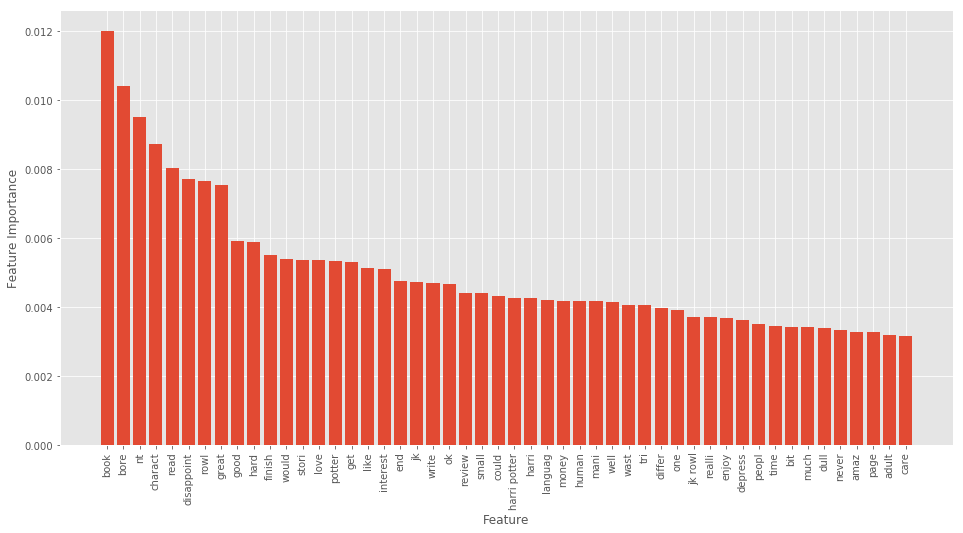

In [47]:
plt.figure(figsize = (16, 8))

plt.bar(
    range(len(feature_importances)),
    [feature_importance[0] for feature_importance in feature_importances]
)

plt.xticks(
    range(len(feature_importances)),
    [feature_importance[1] for feature_importance in feature_importances],
    rotation = 90
)

plt.xlabel('Feature')
plt.ylabel('Feature Importance')